# Kaggle MNIST with fastai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
import os
import numpy as np
import pandas as pd

from glob import glob
from pathlib import Path

from tqdm.auto import tqdm
from tqdm import tqdm_notebook
tqdm.pandas()

from skimage import img_as_int, img_as_uint, img_as_ubyte
from skimage.io import imshow, imsave

from fastai.vision import models as vision_models
from fastai.vision.data import ImageDataBunch
from fastai.vision.learner import cnn_learner
from fastai.metrics import error_rate, accuracy

NUM_CORES = 4
CSV_DATA_PATH = Path(os.path.join('data', 'mnist'))
IMAGE_DATA_PATH = CSV_DATA_PATH/'images'

### Unloading dataset

In [3]:
df_train = pd.read_csv(CSV_DATA_PATH/'train.csv')
df_test = pd.read_csv(CSV_DATA_PATH/'test.csv')
df_train.shape, df_test.shape

((42000, 785), (28000, 784))

In [5]:
np.random.seed(21)

for sub_folder in ['train', 'valid', 'test']:
    if not os.path.isdir(IMAGE_DATA_PATH/sub_folder):
        os.mkdir(IMAGE_DATA_PATH/sub_folder)
        
def unload_images(df, valid_pct=0.2):
    
    columns_pixel = ["pixel{}".format(i) for i in range(784)]
    for row_idx in tqdm_notebook(range(df.shape[0])):
        if 'label' in df.columns:
            label = str(df.loc[row_idx, 'label'])
            
            if np.random.random() < valid_pct:
                img_path = IMAGE_DATA_PATH/'valid'/label
                if not os.path.isdir(img_path):
                    os.mkdir(img_path)
            else:
                img_path = IMAGE_DATA_PATH/'train'/label
                if not os.path.isdir(img_path):
                    os.mkdir(img_path)
                    
            imsave((img_path/"{}.jpg".format(row_idx)).__str__(), img_as_ubyte(df.loc[row_idx, columns_pixel].values.reshape((28, 28)).astype('uint8')), check_contrast=False)
        else:
            imsave((IMAGE_DATA_PATH/'test'/"{}.jpg".format(row_idx)).__str__(), img_as_ubyte(df.loc[row_idx, columns_pixel].values.reshape((28, 28)).astype('uint8')), check_contrast=False)
                
unload_images(df_train)
unload_images(df_test)

### Loading dataset

In [12]:
dataset = ImageDataBunch.from_folder(IMAGE_DATA_PATH, test='test', bs=64)

In [13]:
dataset

ImageDataBunch;

Train: LabelList (33660 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,0,0,0
Path: data\mnist\images;

Valid: LabelList (8340 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
0,0,0,0,0
Path: data\mnist\images;

Test: LabelList (28000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: EmptyLabelList
,,,,
Path: data\mnist\images

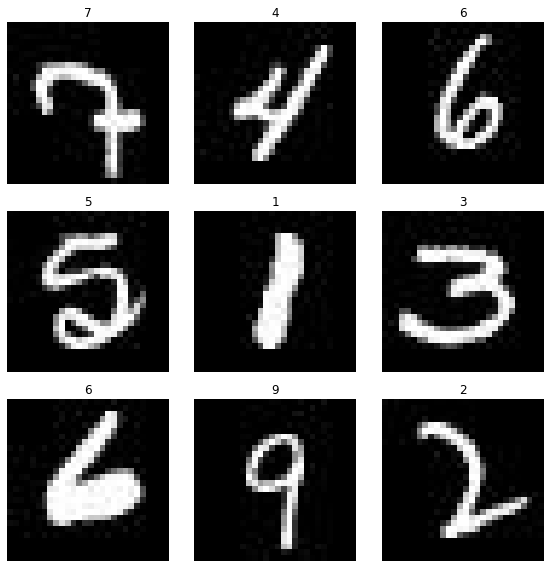

In [14]:
dataset.show_batch(rows=3, figsize=(8, 8))

In [15]:
print(dataset.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [16]:
print(dataset.c)

10


### Training Model

In [19]:
learn = cnn_learner(dataset, vision_models.resnet34, metrics=[accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Milind Dalvi/.cache\torch\checkpoints\resnet34-333f7ec4.pth
100%|█████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:32<00:00, 2.69MB/s]


In [20]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002483B46FBF8>
Traceback (most recent call last):
  File "e:\Miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "e:\Miniconda3\lib\site-packages\torch\utils\data\dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "e:\Miniconda3\lib\multiprocessing\process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "e:\Miniconda3\lib\multiprocessing\popen_spawn_win32.py", line 104, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "e:\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-495233eaf2b4>", line 1, in <module>
    learn.fit_one_cycle(4)
  File "e:\Miniconda3\lib\site-packages\fastai\train.py", line 22, in fit_one_cycle
    learn.fit(cyc_len, max_lr, wd=wd, callbacks=callbacks)
  File "e:\Miniconda3\lib\site-packages\fastai\basic_train.py", line 202, in fit
    fit(epochs, self, metrics=self.metrics, callbacks=self.callbacks+callbacks)
  File "e:\Miniconda3\lib\site-packages\fastai\basic_train.py", line 101, in fit
    loss = loss_batch(learn.model, xb, yb, learn.loss_func, learn.opt, cb_handler)
  File "e:\Miniconda3\lib\site-packages\fastai\basic_train.py", line 26, in loss_batch
    out = model(*xb)
  File "e:\Miniconda3\lib\site-packages\torch\nn\modules\module.py", line 547, in __call__
    result = self.forward(*input, **kwargs)
  File "e:\Mi

KeyboardInterrupt: 